# 0 prepare data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
%matplotlib inline
f='epochs/epoch01_front.mkv'
import  skimage 
from skimage.transform import resize
import keras

Using TensorFlow backend.


### 0  video process

In [2]:
import imageio
try :
    reader = imageio.get_reader(f)
    plt.imshow(reader.get_data(30))
    t0_frame,t1_frame,t2_frame,t3_frame=reader.get_data(0),reader.get_data(1),reader.get_data(2),reader.get_data(3)
    t0_frame=np.array(t0_frame)
    t1_frame=np.array(t1_frame)
    t2_frame=np.array(t2_frame)
    t3_frame=np.array(t3_frame)
except :
    pass

In [3]:
## Preprocess
def img_pre_process(img):
    """
    Processes the image and returns it
    :param img: The image to be processed
    :return: Returns the processed image
    """
    ## Chop off 1/3 from the top and cut bottom 150px(which contains the head of car)
    shape = img.shape
    img = img[int(shape[0]/3):shape[0]-150, 0:shape[1]]
    img=img/255.
    print(img.shape)
    
    ## Resize the image
    resize_img=resize(img, (128, 384), mode='reflect')
    ## Return the image sized as a 4D array
    return resize_img#np.resize(img, (w, h, c))


## 0 .make one frame data for debug

In [4]:
t0_frame=np.load('src/t0_frame.npy')
t1_frame=np.load('src/t1_frame.npy')

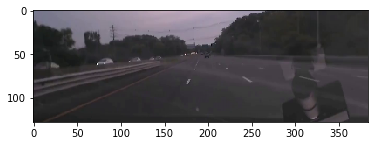

In [5]:
plt.imshow(t0_frame)

In [6]:
# for tf

In [7]:
test_frame0=np.load('src/test_frame0.npy')
test_frame1=np.load('src/test_frame1.npy')

# 1.buid model

In [8]:
from keras.layers import Dense,Deconv2D,Conv2D,BatchNormalization,Activation,Concatenate,Reshape,Conv1D,Permute
from keras.engine.topology import Layer

In [9]:
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

## 1.1 place holdholer 
- a pair of input frame ** I_t ,I_t+1 **
- learning_rate
- steering

In [10]:
def model_input(img_h,img_w,img_c):
    I_t0=tf.placeholder(tf.float32,(None,img_h,img_w,img_c),name='frame_t0')
    I_t1=tf.placeholder(tf.float32,(None,img_h,img_w,img_c),name='frame_t1')
    learning_rate=tf.placeholder(tf.float32)
    steering=tf.placeholder(tf.float32,(None,1),name='steering')
    
    return I_t0,I_t1,learning_rate,steering

### 1.2 place holder shape test

In [11]:
img_h,img_w,img_c=128,384,3
I_t0,I_t1,learning_rate,steering=model_input(img_h,img_w,img_c)
assert I_t0.shape.as_list()==[None,128,384,3]
assert I_t1.shape.as_list()==[None,128,384,3]
assert steering.shape.as_list()==[None,1]

##  1.3 basic structure of conv ,dconv

![](src/net2.png)

![](src/w1.png)

![](src/net.png)
![](src/w2.png)

In [12]:
def conv(h_0,filters,kernel_size,strides):
        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0,stddev=0.0001)
    
        h1=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer=kernel_initializer)(h_0)
        h1_bn=BatchNormalization()(h1,training=True)
        h1_o=Activation('relu')(h1_bn)
        return h1_o
def deconv(h_0,filters,kernel_size,strides):
        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0,stddev=0.0001)
    
        h1=Deconv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer=kernel_initializer)(h_0)
        h1_bn=BatchNormalization()(h1,training=True)
        h1_o=Activation('relu')(h1_bn)
        return h1_o


In [13]:
def conv_deconv_net(frame):

    ###to deconv
    h10_o=conv(frame,filters=32,kernel_size=3,strides=1)

    h11_o=conv(h10_o,filters=64,kernel_size=3,strides=2)
    ###to deconv
    h20_o=conv(h11_o,filters=64,kernel_size=3,strides=1)

    h21_o=conv(h20_o,filters=128,kernel_size=3,strides=2)

    ###to deconv
    h30_o=conv(h21_o,filters=128,kernel_size=3,strides=1)

    h31_o=conv(h30_o,filters=256,kernel_size=3,strides=2)
    ###to deconv
    h40_o=conv(h31_o,filters=256,kernel_size=3,strides=1)

    h41_o=conv(h40_o,filters=512,kernel_size=3,strides=2)
    ###to deconv
    h50_o=conv(h41_o,filters=512,kernel_size=3,strides=1)

    h51_o=conv(h50_o,filters=1024,kernel_size=3,strides=2)
    #embeding layer
    embeding=conv(h51_o,filters=1024,kernel_size=3,strides=1)


    #deconv
    d5=deconv(embeding,filters=512,kernel_size=3,strides=2)
    d4_i=Concatenate(axis=-1)([d5,h50_o])

    d4=deconv(d4_i,filters=256,kernel_size=3,strides=2)

    d3_i=Concatenate(axis=-1)([d4,h40_o])

    d3=deconv(d3_i,filters=128,kernel_size=3,strides=2)



    d2_i=Concatenate(axis=-1)([d3,h30_o])

    d2=deconv(d2_i,filters=64,kernel_size=3,strides=2)


    d1_i=Concatenate(axis=-1)([d2,h20_o])

    out=deconv(d1_i,filters=32,kernel_size=3,strides=2)


    return out,embeding

###  2 depth_net

In [14]:
def clip_relu(x):

    x=tf.clip_by_value(x, 1, 100)
    
    return x
def depth_net(frame):

    top,_=conv_deconv_net(frame)
    top=Conv2D(filters=1,kernel_size=1,strides=1,padding='same',kernel_initializer=keras.initializers.glorot_normal())(top)
    depth=Activation(clip_relu)(top)

    return depth
    

###  2.2 depth to point cloud
linear transformation without trainabel weight

you shulud input camera intrinsics (cx,cy,f) to define this layer

if intrinsics is unavalibel ,use [0.5,0.5,1.0] as default

![](src/param4.png)

In [15]:
class Cloud_transformer():
    def __init__(self,intrinsics=[0.5,0.5,1.0], **kwargs):
        self.output_dim = 3
        self.cam_intrinsics = intrinsics
        self.build()

    def build(self):
        self.cx_=self.cam_intrinsics[0]
        
        self.cy_=self.cam_intrinsics[1]
        
        self.cf_=self.cam_intrinsics[2]
        
        self.cx=tf.constant(self.cam_intrinsics[0],dtype=tf.float32)
        
        self.cy=tf.constant(self.cam_intrinsics[1],dtype=tf.float32)
        
        self.cf=tf.constant(self.cam_intrinsics[2],dtype=tf.float32)
        
    def mesh_grid(self,width,height):
        # get 
        """
        [(xi/w-cx)/f,(yi/h-cy)/f,1]
        
        next just 
        
        d*[(xi/w-cx)/f,(yi/h-cy)/f,1]
         to get [Xi,Yi,Zi]
        
        """
      
        x_linspace=tf.linspace(-self.cx_,1-self.cx_,width)
        y_linspace=tf.linspace(-self.cy_,1-self.cy_,height)
        
#         x_cord,y_cord=tf.meshgrid(x_linspace,y_linspace)
        y_cord,x_cord=tf.meshgrid(y_linspace,x_linspace)
        
        
        x_cord=tf.reshape(x_cord,[-1])
        y_cord=tf.reshape(y_cord,[-1])
        
        f_=tf.ones_like(x_cord)
        
        x_=tf.div(x_cord,self.cf)
        y_=tf.div(y_cord,self.cf)
        
        grid=tf.concat([x_,y_,f_],0)
        return grid
        
    def transform(self,x):
        
        #get input shape
        batch_size=tf.shape(x)[0]
        width=tf.shape(x)[1]
        height=tf.shape(x)[2]
        channel=tf.shape(x)[3]
        batch_size=tf.cast(batch_size,tf.int32)
        width=tf.cast(width,tf.int32)
        height=tf.cast(height,tf.int32)
        channel=tf.cast(channel,tf.int32)
        
        
        #grid
        grid=self.mesh_grid(width,height)
        grid=tf.expand_dims(grid,0)
        grid=tf.reshape(grid,[-1])
        
        
        grid_stack = tf.tile(grid, tf.stack([batch_size]))
        grid_stack=tf.reshape(grid_stack,[batch_size,3,-1])
        depth=tf.reshape(x,[batch_size,1,-1])
        depth=tf.concat([depth]*self.output_dim,1)
        
        point_cloud=tf.multiply(depth,grid_stack)
#         pc3=tf.reshape(pc3,[batch_size,width,height,self.output_dim])
        
        return point_cloud

    def __call__(self, x):
        point_cloud=self.transform(x)
        return point_cloud


In [16]:
def structure_net(input_frame,reuse=False):
    with tf.variable_scope('structure_net',reuse=reuse):
        depth_output=depth_net(input_frame)
        point_cloud_output=Cloud_transformer()(depth_output)
        return point_cloud_output,depth_output
        
        
    

##  3. motion net
#### 3.1 param_net
get 3D rigid motions parameter

- p [px,py,pz]   rotation pivot points :use a sigmoid activation to predict a weight avarage in a 20m*30m grid  
- t [tx,ty,tz]    linear movement translation 
- r [sin(a),sin(b),sin(y)]  Euler angle representation  


![](src/param1.png)

In [17]:
def sin_relu(x):
    x=tf.clip_by_value(x, -1., 1.)
    
    return x

def param_net(frame_t0,frame_t1,k_obj=4,):
    init=keras.initializers.TruncatedNormal(mean=0.0,stddev=0.0001)
    frame_pair=tf.concat([frame_t0,frame_t1],-1)
    top,embed=conv_deconv_net(frame_pair)
    mask=Conv2D(filters=k_obj,kernel_size=1,strides=1,padding='same',kernel_initializer=init)(top)
    
    
    embed=Dense(512,kernel_initializer=init)(embed)
    embed=Dense(512,kernel_initializer=init)(embed)
    embed=Reshape([-1])(embed)
    
    
    cam_t_=Dense(3,kernel_initializer=init)(embed)
    cam_t=Activation('relu')(cam_t_)
    cam_p=Dense(600,kernel_initializer=init)(embed)
    
    cam_p=Activation('relu')(cam_p)
    cam_r=Dense(3,kernel_initializer=init)(embed)
    
    cam_r=Activation(sin_relu)(cam_r)
    
    
    
    obj_mask= Activation('sigmoid')(mask) 
    obj_t=Activation('relu')(Dense(3*k_obj,kernel_initializer=init)(embed))
    obj_t=tf.reshape(obj_t,(-1,k_obj,3))
    obj_p=Activation('relu')(Dense(600*k_obj,kernel_initializer=init)(embed))
    obj_p=tf.reshape(obj_p,(-1,k_obj,600))
    
    obj_r=Activation(sin_relu)(Dense(3*k_obj,kernel_initializer=init)(embed))
    obj_r=tf.reshape(obj_r,(-1,k_obj,3))
    
    return [cam_t,cam_p,cam_r],[obj_t,obj_p, obj_r,obj_mask]


 # 3.2 get Optical_flow anf motion field

![](src/param2.png)

In [18]:
class Optical_transformer():

    def __init__(self,intrinsics=[0.5,0.5,1.0],img_shape=[384,128], **kwargs):
        
        self.cam_intrinsics = intrinsics
        self.img_w=self.np_tf(img_shape[0])
        self.img_h=self.np_tf(img_shape[1])
        self.img_w_=float(img_shape[0])
        self.img_h_=float(img_shape[1])
        
        
        
        self.cx_=self.cam_intrinsics[0]
        
        self.cy_=self.cam_intrinsics[1]
        
        self.cf_=self.cam_intrinsics[2]
        
        
        
        self.cx=self.np_tf(self.cam_intrinsics[0])
        
        self.cy=self.np_tf(self.cam_intrinsics[1])
        
        self.cf=self.np_tf(self.cam_intrinsics[2])
        

        so3_a=np.array([
            [0,-1,0,1,0,0,0,0,0],
            [1,0,0,0,1,0,0,0,0],
            [0,0,0,0,0,0,0,0,1]
        ])

        so3_b=np.array([
            [0,0,1,0,0,0,-1,0,0],
            [1,0,0,0,0,0,0,0,1],
            [0,0,0,0,1,0,0,0,0]
        ])

        so3_y=np.array([
            [0,0,0,0,0,-1,0,1,0],
            [0,0,0,0,1,0,0,0,1],
            [1,0,0,0,0,0,0,0,0]
        ])

#         so3_param=np.concatenate([so3_a,so3_b,so3_y],0)
        self.so3_a=self.np_tf(so3_a)
        self.so3_b=self.np_tf(so3_b)
        self.so3_y=self.np_tf(so3_y)
        
  
    def np_tf(self,array):
        return tf.constant(array,tf.float32)
    

    def build(self,cam_motion,obj_motion,x):
                
        self.cam_motion=cam_motion
        
        self.obj_motion=obj_motion
        self.mask_size=obj_motion[0].shape.as_list()[1]
        self.x_shape=x.shape.as_list()
        
    
#    tranformation     
    def so3_mat(self,sin):
        #input :sin a,sin b,sin y 
        #return : SO3
        sin=tf.expand_dims(sin,-1)
        cos=tf.sqrt(tf.ones_like(sin)-tf.square(sin))
        t=tf.concat([sin,cos,tf.ones_like(sin)],-1)
        t_a=tf.slice(t,[0,0,0],[-1,1,-1])
        t_b=tf.slice(t,[0,1,0],[-1,1,-1])
        t_y=tf.slice(t,[0,2,0],[-1,1,-1])
        t_a=tf.reshape(t_a,(-1,3))
        t_b=tf.reshape(t_b,(-1,3))
        t_y=tf.reshape(t_y,(-1,3))
        
        soa=tf.matmul(t_a,self.so3_a)
        soa=tf.reshape(soa,(-1,3,3))
        
        sob=tf.matmul(t_b,self.so3_b)
        sob=tf.reshape(sob,(-1,3,3))
        soy=tf.matmul(t_y,self.so3_y)
        soy=tf.reshape(soy,(-1,3,3))
   
        so3=tf.matmul(soa,  tf.matmul(sob,soy))
        return so3
    def pior_pont(self,p):
        batch_size=p.shape.as_list()[0]
        p_ret=tf.reshape(p,(-1,30,20))
        p_y=tf.reduce_sum(p_ret,1)
        p_x=tf.reduce_sum(p_ret,2)
        x_loc=tf.linspace(-30.0,30.0,30)
        y_loc=tf.linspace(-20.,20.,20)
        P_x_loc=tf.reduce_mean(tf.multiply(p_x,x_loc))
        P_x_loc=tf.reshape(P_x_loc,(-1,1))
        P_y_loc=tf.reduce_mean(tf.multiply(p_y,y_loc))
        P_y_loc=tf.reshape(P_y_loc,(-1,1))
        
        ground=tf.ones_like(P_y_loc)
        P=tf.concat([P_x_loc,P_y_loc,ground],1)
        
        
        return P
    
    def rigid_motion(self,x,R,p,t):
        p=tf.expand_dims(p,-1)
        
        t=tf.expand_dims(t,-1)
        
        motion=tf.add(tf.matmul(R,tf.subtract(x,p)),t)

        return motion
          
    
    def cam_motion_transform(self,x):
        t,p,sin=self.cam_motion
        p=self.pior_pont(p)
        R=self.so3_mat(sin)
        X=self.rigid_motion(x,R,p,t)
        
        
        return X
        
  
    def obj_motion_transform(self,x_input):
        t,p,sin,mask=self.obj_motion
        p=self.pior_pont(p)
        sin=tf.reshape(sin,(-1,3))
        p=tf.reshape(p,(-1,3))
        t=tf.reshape(t,(-1,3))
        x_in=tf.expand_dims(x_input,1)
        x_exp=tf.concat([x_in]*self.mask_size,1)
        x_=tf.reshape(x_exp,(-1,3,384*128))
        
        
        R=self.so3_mat(sin)
        
        x=self.rigid_motion(x_,R,p,t)
        
        
        
        x=tf.reshape(x,(-1,self.mask_size,3,384*128))
        x,motion_map=self.mask_motion(x,mask,x_exp)
        X=tf.add(x_input,x)
        
        
        return X,motion_map
    
    def mask_motion(self,x,mask,x_exp):
        mask=tf.reshape(mask,(-1,self.mask_size,1,384*128))
        x=tf.subtract(x,x_exp)
        motion_map=tf.multiply(x,mask)
#         x=tf.reshape(x,(-1,self.mask_size,3,384*128))
        x=tf.reduce_sum(motion_map,1)
#         print(x.shape.as_list())
        
        return x,motion_map
        
        
    def tranform_2d(self,x):
        x_3d=tf.slice(x,(0,0,0),(-1,1,49152))
        y_3d=tf.slice(x,(0,1,0),(-1,1,49152))
        z_3d=tf.slice(x,(0,2,0),(-1,1,49152))
        x_z=tf.div(x_3d,z_3d)
        y_z=tf.div(y_3d,z_3d)
        
#         x_2d=tf.multiply(self.img_w,tf.add(tf.multiply(self.cf,x_z),self.cx))
#         y_2d=tf.multiply(self.img_h,tf.add(tf.multiply(self.cf,y_z),self.cy))
        x_2d=tf.add(tf.multiply(self.cf,x_z),self.cx)
        y_2d=tf.add(tf.multiply(self.cf,y_z),self.cy)
        pos_2d_new=tf.concat([x_2d,y_2d],1)
        return pos_2d_new

    def get_flow(self,pos_2d_new):
        
        
        x_linspace = tf.linspace(0.,1.,int(self.img_w_))
        y_linspace = tf.linspace(0.,1.,int(self.img_h_))
        y_linspace,x_linspace = tf.meshgrid( y_linspace,x_linspace)
        x_linspace = tf.reshape(x_linspace, [1,-1])
        y_linspace = tf.reshape(y_linspace, [1,-1])
        pos_ori=tf.concat([x_linspace,y_linspace],0)
        flow=tf.subtract(pos_2d_new,pos_ori)
        
        
        return flow

  
    def __call__(self,x,cam_motion,obj_motion,):
        self.build( cam_motion,obj_motion,x)

        
        point_cloud,motion_map=self.obj_motion_transform(x)
        
        
        point_cloud=self.cam_motion_transform(point_cloud)
        pix_pos=self.tranform_2d(point_cloud)
        flow=self.get_flow(pix_pos)
        motion_map=tf.reshape(motion_map,(-1,img_h,img_w,1))
        return pix_pos,flow,point_cloud,motion_map



In [19]:
def motion_net(input_frame_0,input_frame_1,point_cloud_0,reuse=False):
    with tf.variable_scope('motion_net',reuse=reuse):
        cam_motion,obj_motion=param_net(input_frame_0,input_frame_1,k_obj=4,)
        pix_pos,flow,point_cloud,motion_map=Optical_transformer()(point_cloud_0,cam_motion,obj_motion,)
        return pix_pos,flow,point_cloud,motion_map
        

 #  3.3 build loss function
 
base on optical flow , use bilieaner interpolate ,to sample the pixel in T_t+1 

compute the color  loss

![](src/loss1.png)

In [20]:
class get_frame_loss():
    def __init__(self):
        self.output_size=[128,384]
    def __call__(self,frame0,frame1,pos_2d_new,reuse=False):
        with tf.variable_scope('frame_loss',reuse=reuse):
            batch_size = tf.shape(frame1)[0]
            height = 128
            width = 384
            num_channels = 3
            output_height=128
            output_width=384



            x_s = tf.slice(pos_2d_new, [0, 0, 0], [-1, 1, -1])
            y_s = tf.slice(pos_2d_new, [0, 1, 0], [-1, 1, -1])
            x_s_flatten = tf.reshape(x_s, [-1])
            y_s_flatten = tf.reshape(y_s, [-1])

            transformed_image = self._interpolate(frame1,
                                                    x_s_flatten,
                                                    y_s_flatten,
                                                    self.output_size)

            transformed_image = tf.reshape(transformed_image, shape=(-1,
                                                                    output_height,
                                                                    output_width,
                                                                     num_channels))

            loss=self.compute_loss( frame0,transformed_image )
            ####test--------------------------------------------
            return loss
    
    
    def compute_loss(self,frame0,transformed_image):
        loss=tf.reduce_mean(tf.abs(tf.subtract( frame0,transformed_image)))
        return loss
        
        
        
        
    def _interpolate(self, image, x, y, output_size):
        batch_size = tf.shape(image)[0]
        height = 128
        width = 384
        num_channels = tf.shape(image)[3]

        x = tf.cast(x , dtype='float32')
        y = tf.cast(y , dtype='float32')

        height_float = tf.cast(height, dtype='float32')
        width_float = tf.cast(width, dtype='float32')

        output_height = output_size[0]
        output_width  = output_size[1]

        x =x*(width_float)
        y =y*(height_float)

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        max_y = tf.cast(height - 1, dtype='int32')
        max_x = tf.cast(width - 1,  dtype='int32')
        
        zero = tf.zeros([], dtype='int32')

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        flat_image_dimensions = width*height
        pixels_batch = tf.range(batch_size)*flat_image_dimensions
        flat_output_dimensions = output_height*output_width
        base = self._repeat(pixels_batch, flat_output_dimensions)
        base_y0 = base + y0*width
        base_y1 = base + y1*width
        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = tf.reshape(image, shape=(-1, num_channels))
        flat_image = tf.cast(flat_image, dtype='float32')
        pixel_values_a = tf.gather(flat_image, indices_a)
        pixel_values_b = tf.gather(flat_image, indices_b)
        pixel_values_c = tf.gather(flat_image, indices_c)
        pixel_values_d = tf.gather(flat_image, indices_d)
        




        x0 = tf.cast(x0, 'float32')
        x1 = tf.cast(x1, 'float32')
        y0 = tf.cast(y0, 'float32')
        y1 = tf.cast(y1, 'float32')

        area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
        output = tf.add_n([area_a*pixel_values_a,
                           area_b*pixel_values_b,
                           area_c*pixel_values_c,
                           area_d*pixel_values_d])
        return output
        
    def _repeat(self, x, num_repeats):
        ones = tf.ones((1, num_repeats), dtype='int32')
        x = tf.reshape(x, shape=(-1,1))
        x = tf.matmul(x, ones)
        return tf.reshape(x, [-1])
    
    

![](src/loss2.png)

##### use conv with fixed weights to compute gradient 

In [21]:
class get_smooth_loss():
    def __init__(self,kernel=[[1,2,1],[0,0,0],[-1,-2,-1]],order=1):
        self.kernel=np.array(kernel)
        self.order=order
        
        
    def build(self,field_c):
        v_kernel=self.kernel
        h_kernel=self.kernel
        h_init=keras.initializers.Constant(value=h_kernel)
        v_init=keras.initializers.Constant(value=v_kernel)
        
        self.conv_h=Conv2D(filters=field_c,kernel_size=3,strides=1,kernel_initializer=h_init,padding='same')
        self.conv_h.trainable=False
        self.conv_v=Conv2D(filters=field_c,kernel_size=3,strides=1,kernel_initializer=v_init,padding='same')
        self.conv_v.trainable=False
        
        
    def compute_gradient(self,field):
        loss_v=self.conv_v(field)
        loss_h=self.conv_h(field)
        
        gradient_loss=loss_h+loss_v
        
        return gradient_loss
        
        
    def compute_loss(self,field):
        f1_gradient_loss=self.compute_gradient(field)
        

        
        if self.order==1:
            loss=tf.reduce_mean(tf.abs(f1_gradient_loss),-1)
            loss=tf.reduce_mean(loss)
            
        if self.order==2:
            f2_gradient_loss=self.compute_gradient(f1_gradient_loss)
            
            loss=tf.reduce_mean(tf.abs(f2_gradient_loss),-1)
            loss=tf.reduce_mean(loss)

            
        return loss

        
        
        

    
    def __call__(self,field,loss_type=None,reuse=False):
        with tf.variable_scope(loss_type,reuse=reuse):
            

            if loss_type=='flow':
                field=Permute((2,1))(field)
                field=tf.reshape(field,(-1,128,384,2))
                field_c=field.shape.as_list()[1]
    # #         if loss_type=='depth':
    # #             field=field#tf.reshape(field,(-1,128,384))
    # #             field_c=1
    #         else:

            field_c=field.shape.as_list()[-1]

            self.build(field_c)
            loss=self.compute_loss(field)
            return loss
        


##### maybe same as the first loss
![](src/loss3.png)

In [22]:
class get_fb_depth_loss():
    def __init__(self):
        self.output_size=[128,384]
    def __call__(self,depth0,depth1,pos_2d_new,motion,reuse=False):
        with tf.variable_scope('fb_depth_loss',reuse=reuse):
            batch_size = tf.shape(depth0)[0]
            height = tf.shape(depth0)[1]
            width = tf.shape(depth0)[2]
            num_channels = tf.shape(depth0)[3]
            output_height=self.output_size[0]
            output_width=self.output_size[1]



            x_s = tf.slice(pos_2d_new, [0, 0, 0], [-1, 1, -1],name='err')
            y_s = tf.slice(pos_2d_new, [0, 1, 0], [-1, 1, -1])
            x_s_flatten = tf.reshape(x_s, [-1])
            y_s_flatten = tf.reshape(y_s, [-1])

            transformed_depth1 = self._interpolate(depth1,
                                                    x_s_flatten,
                                                    y_s_flatten,
                                                    self.output_size)

            transformed_depth1 = tf.reshape(transformed_depth1, shape=(-1,
                                                                    output_height,
                                                                    output_width,
                                                                     num_channels))

            motion_z=tf.slice(motion,[0,2,0],[-1,1,-1])
            motion_z=tf.reshape(motion_z,(-1,output_height,output_width,1))
            transformed_depth0=tf.add(depth0,motion_z)
            loss=self.compute_loss( transformed_depth0,transformed_depth1 )
        return loss
    
    
    def compute_loss(self,transformed_depth0,transformed_depth1):
        
        loss=tf.reduce_mean(tf.abs(tf.subtract( transformed_depth0,transformed_depth1)))
        return loss
        
        
        
        
    def _interpolate(self, image, x, y, output_size):
        batch_size = tf.shape(image)[0]
        height = tf.shape(image)[1]
        width = tf.shape(image)[2]
        num_channels = tf.shape(image)[3]

        x = tf.cast(x , dtype='float32')
        y = tf.cast(y , dtype='float32')

        height_float = tf.cast(height, dtype='float32')
        width_float = tf.cast(width, dtype='float32')

        output_height = output_size[0]
        output_width  = output_size[1]

        x =x*(width_float)
        y = y*(height_float)

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        max_y = tf.cast(height - 1, dtype='int32')
        max_x = tf.cast(width - 1,  dtype='int32')
        zero = tf.zeros([], dtype='int32')

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        flat_image_dimensions = width*height
        pixels_batch = tf.range(batch_size)*flat_image_dimensions
        flat_output_dimensions = output_height*output_width
        base = self._repeat(pixels_batch, flat_output_dimensions)
        base_y0 = base + y0*width
        base_y1 = base + y1*width
        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = tf.reshape(image, shape=(-1, num_channels))
        flat_image = tf.cast(flat_image, dtype='float32')
        pixel_values_a = tf.gather(flat_image, indices_a)
        pixel_values_b = tf.gather(flat_image, indices_b)
        pixel_values_c = tf.gather(flat_image, indices_c)
        pixel_values_d = tf.gather(flat_image, indices_d)

        x0 = tf.cast(x0, 'float32')
        x1 = tf.cast(x1, 'float32')
        y0 = tf.cast(y0, 'float32')
        y1 = tf.cast(y1, 'float32')

        area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
        output = tf.add_n([area_a*pixel_values_a,
                           area_b*pixel_values_b,
                           area_c*pixel_values_c,
                           area_d*pixel_values_d])
        return output
        
    def _repeat(self, x, num_repeats):
        ones = tf.ones((1, num_repeats), dtype='int32')
        x = tf.reshape(x, shape=(-1,1))
        x = tf.matmul(x, ones)
        return tf.reshape(x, [-1])
    
    

##  train model

In [23]:
f_point_cloud_1,f_depth_output=structure_net(I_t0)
b_point_cloud_1,b_depth_output=structure_net(I_t1,reuse=True)



In [24]:
f_pix_pos,f_flow,f_point_cloud_2,f_motion_map=motion_net(I_t0,I_t1,f_point_cloud_1)
b_pix_pos,b_flow,b_point_cloud_2,b_motion_map=motion_net(I_t1,I_t0,b_point_cloud_1,reuse=True)

In [25]:
f_frame_loss=get_frame_loss()(I_t0,I_t1,f_pix_pos)
b_frame_loss=get_frame_loss()(I_t1,I_t0,b_pix_pos,reuse=True)

In [26]:
f_flow_sm_loss=get_smooth_loss(order=1)(f_flow,'flow')
b_flow_sm_loss=get_smooth_loss(order=1)(b_flow,'flow',reuse=True)

f_depth_sm_loss=get_smooth_loss(order=1)(f_depth_output,'depth')

b_depth_sm_loss=get_smooth_loss(order=1)(b_depth_output,'depth',reuse=True)

f_motion_sm_loss=get_smooth_loss(order=1)(f_motion_map,'motion')

b_motion_sm_loss=get_smooth_loss(order=1)(b_motion_map,'motion',reuse=True)


In [27]:
f_depth_loss=get_fb_depth_loss()(f_depth_output,b_depth_output,f_pix_pos,f_point_cloud_1)
b_depth_loss=get_fb_depth_loss()(b_depth_output,f_depth_output,b_pix_pos,b_point_cloud_1,reuse=True)

In [28]:
toal_loss=f_depth_loss+f_depth_sm_loss+f_motion_sm_loss+f_flow_sm_loss+f_frame_loss+\
   b_depth_loss+b_depth_sm_loss+b_motion_sm_loss+b_flow_sm_loss+b_frame_loss
train_op=tf.train.AdamOptimizer(learning_rate=0.0003,beta1=0.9).minimize(toal_loss)

/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [29]:
tf.summary.scalar('toal_loss',toal_loss)
tf.summary.image('b_depth_output',b_depth_output,1)
tf.summary.image('f_depth_output',f_depth_output,1)

meger_summary=tf.summary.merge_all()

In [30]:
!rm -r /tmp/sfm

In [31]:
!mkdir checkpoint

In [32]:
write=tf.summary.FileWriter('/tmp/sfm')
write.add_graph(sess.graph)


In [42]:
sess.run(tf.global_variables_initializer())
saver=tf.train.Saver()
for step in range(10000):
    ckpt = tf.train.get_checkpoint_state('./checkpoint/')
    if (step==0) and ckpt and ckpt.model_checkpoint_path:
        print('load model')
        saver.restore(sess, ckpt.model_checkpoint_path)

    feed_dict={I_t0:test_frame0,I_t1: test_frame1}
    
    _=sess.run([train_op],feed_dict=feed_dict)
#     

    if step%20==0:
        train_loss=sess.run(toal_loss,feed_dict=feed_dict)
        print(train_loss)
        
    if step%100==0:
        s=sess.run(meger_summary,feed_dict=feed_dict )
        write.add_summary(s,step)
        saver.save(sess, './checkpoint/'+'my-model', global_step=step)


load model
15.3817
109.64
57.9887
17.5192
14.093
13.3739
12.8767
12.8623
12.477
12.9701
12.5193
12.2696
12.0945
11.8624
11.8663
11.9404
11.7443
11.8982
11.7655
12.0749
11.6131
11.9734
11.9707
11.5679
11.6804
11.571
11.5112
11.3576
11.3435
11.8275
11.4573
11.3789
11.5034
11.428
11.1995
11.4024
11.2043
11.4465
11.4268
11.6385
11.17
11.0543
20.0159
13.5467
12.1896
11.4592
11.6704
11.201
11.2243
11.3317
11.1422
10.7148
11.0731
11.3487
10.6563
10.7048
10.6398
10.6242
10.5521
10.6531
10.8216
10.704
10.5219
10.5184
10.4145
10.5607
10.7068
10.6614
10.4791


KeyboardInterrupt: 